# Feature Importance (SHAP)
- Docs: https://github.com/shap/shap
- Tutorial: [Deep Learning Model Explainability Using SHAP | Explainable AI | Data Science | Machine Learning](https://youtu.be/Ty7qf3mV_Qc?si=nMEEcLIsG_xZgabS)
- Explanation: [SHAP values for beginners | What they mean and their applications](https://www.youtube.com/watch?v=MQ6fFDwjuco)

In [ ]:
import shap

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

np.random.seed(42)

VERSION = '20240107184239' ## TO DO: Change to your model version (timestamp of your training)

## 1. Read training data

In [ ]:
numerical = [
            'host_response_rate', 'host_acceptance_rate', 'host_total_listings_count',
            'accommodates', 'bathroom_qty', 'bedrooms', 'beds',
            ]
geo = ['latitude','longitude']
categorical = [
                'host_response_time','host_is_superhost', 
                'host_verifications_work_email','host_has_profile_pic',
                'neighbourhood_cleansed', 'room_type', 'property_description', 'bathroom_type', 
                'gym','pool','kitchen','parking','washer','dryer','conditioning','heating','workspace',
                'tv','hair dryer','iron','hot tub','crib','bbq','fireplace','smoking', 'coffee maker', 
               'instant_bookable',
              ]
label=['log_price']

In [ ]:
train_dataset = pd.read_pickle(f"../data/train/v_{VERSION}/train_dataset.pkl")
train_features = train_dataset.drop(['log_price'], axis = 1)
train_features.head()

,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,bathroom_qty,bedrooms,beds,latitude,longitude,host_response_time_within_a_day,...,tv_1,hair dryer_1,iron_1,hot tub_1,crib_1,bbq_1,fireplace_1,smoking_1,coffee maker_1,instant_bookable_True
5434,1.0,0.79,6.0,2.0,1.0,1.0,1.0,19.355921,-99.173973,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20726,1.0,1.00,1.0,4.0,1.0,1.0,2.0,19.434452,-99.190392,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
24644,1.0,1.00,19.0,4.0,1.0,1.0,2.0,19.428835,-99.167885,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4991,1.0,1.00,1.0,4.0,2.0,2.0,2.0,19.405701,-99.173172,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18412,1.0,1.00,224.0,4.0,1.0,1.0,2.0,19.446989,-99.172211,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
complete_categorical=[i for i in train_features.columns if i not in geo+numerical]

In [ ]:
len(complete_categorical)+9

97

## 2. Sample training data

In [ ]:
sample_data = train_features.sample(frac=.1, random_state=0)
sample_data.shape

(1646, 97)

## 3. Read model

In [ ]:
model = keras.models.load_model(f'../models/v_{VERSION}/model.keras', safe_mode=False)

In [ ]:
model

<keras.src.engine.functional.Functional>

In [ ]:
# We need a function that takes a matrix of samples (# samples x # features) and outputs the model predictions
def model_predict(data_as_matrix):
    return model.predict(data_as_matrix)

## 4. SHAP (prepare w training data)

First, order the training features:

In [ ]:
train_features_ordered = sample_data[geo+numerical+complete_categorical]
train_features_ordered.head()

,latitude,longitude,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,bathroom_qty,bedrooms,beds,host_response_time_within_a_day,...,tv_1,hair dryer_1,iron_1,hot tub_1,crib_1,bbq_1,fireplace_1,smoking_1,coffee maker_1,instant_bookable_True
16282,19.440889,-99.165443,1.00,1.00,3.0,2.0,1.0,1.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18610,19.434441,-99.178436,1.00,1.00,12.0,2.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
10794,19.425770,-99.159576,1.00,0.99,42.0,2.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8437,19.418871,-99.171120,1.00,1.00,18.0,2.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
17316,19.406441,-99.175041,0.99,1.00,68.0,3.0,2.5,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Now, obtain and order the example we want to explain:

In [ ]:
example = {
    'host_response_rate': [.98], # My grandparents respond 98% of the time
     'host_acceptance_rate': [ 1], # Right now they always accept new guests
     'host_total_listings_count': [ 4], # They have 4 units
     'latitude': [ 19.37137], # ...
     'longitude': [ -99.19327],
     'accommodates': [ 4],
     'bathroom_qty': [ 2],
     'bedrooms': [ 2],
     'beds': [ 3],
    'host_response_time':['within_a_day'],
    'host_is_superhost': [False],
    'host_verifications_work_email':[0],
    'host_has_profile_pic': [True],
    'neighbourhood_cleansed': ['alvaro_obregon'],
    'room_type': ['entire_home_apt'],
    'property_description': ['home/apt'],
    'bathroom_type':['private_bath'],
     'gym': [0],
     'pool': [0],
     'kitchen': [1],
     'parking': [1],
     'washer': [1],
     'dryer': [1],
     'conditioning': [0],
     'heating': [0],
     'workspace': [0],
     'tv': [1],
     'hair dryer': [0],
     'iron': [1],
     'hot tub': [0],
     'crib': [0],
     'bbq': [0],
     'fireplace': [0],
     'smoking': [0],
     'coffee maker': [1],
     'instant_bookable': ['True'],
    
}
example_df = pd.DataFrame.from_dict(example)

In [ ]:
example_df['kitchen']

0    1
Name: kitchen, dtype: int64

In [ ]:
# 1. Apply pd.get_dummies to the example_df
example_df = pd.get_dummies(example_df, columns=categorical, drop_first=False)

In [ ]:
example_df

,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathroom_qty,bedrooms,beds,host_response_time_within_a_day,...,tv_1,hair dryer_0,iron_1,hot tub_0,crib_0,bbq_0,fireplace_0,smoking_0,coffee maker_1,instant_bookable_True
0,0.98,1,4,19.37137,-99.19327,4,2,2,3,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# 2. Get the structure of the original dataframe
original_structure = train_features.columns

# 3. Add missing columns to example_df
missing_cols = set(original_structure) - set(example_df.columns)
for col in missing_cols:
    example_df[col] = 0

# 4. Ensure the order of columns is the same as in 'data'
example_df = example_df[original_structure]

# 5. Reformat
example_df=example_df.astype('float32')

example_df.head()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,bathroom_qty,bedrooms,beds,latitude,longitude,host_response_time_within_a_day,...,tv_1,hair dryer_1,iron_1,hot tub_1,crib_1,bbq_1,fireplace_1,smoking_1,coffee maker_1,instant_bookable_True
0,0.98,1.0,4.0,4.0,2.0,2.0,3.0,19.37137,-99.193268,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
example_df['kitchen_1']

0    1.0
Name: kitchen_1, dtype: float32

In [ ]:
test_features_ordered = example_df[geo+numerical+complete_categorical]

In [ ]:
test_features_ordered

,latitude,longitude,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,bathroom_qty,bedrooms,beds,host_response_time_within_a_day,...,tv_1,hair dryer_1,iron_1,hot tub_1,crib_1,bbq_1,fireplace_1,smoking_1,coffee maker_1,instant_bookable_True
0,19.37137,-99.193268,0.98,1.0,4.0,4.0,2.0,2.0,3.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Now, we obtain the Shapley values:

52/52 [==============================] - 0s 971us/step


Using 1646 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

113369/113369 [==============================] - 86s 755us/step


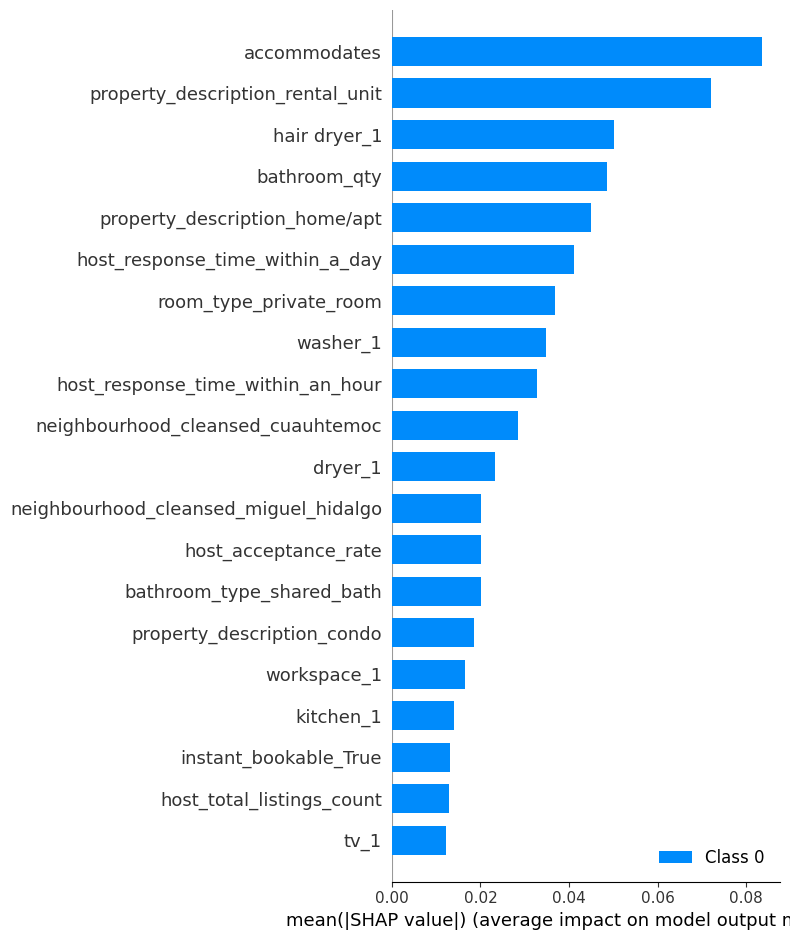

In [ ]:
# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, train_features_ordered.values)  # Using a representative subset

# Compute SHAP values for the first 100 samples of your test set
shap_values = explainer.shap_values(test_features_ordered.values)

# Plot the SHAP values
shap.summary_plot(shap_values, test_features_ordered.iloc[0:100])

Now, let's observe the most important features on this explanation and their impact:

In [ ]:
print("base value =", explainer.expected_value)
print("base value in MXN pesos =", np.exp(explainer.expected_value))

# Convert the SHAP values for the first test example into a DataFrame
shap_df = pd.DataFrame(shap_values[0], columns=test_features_ordered.columns)
shap_df =shap_df.T
shap_df = shap_df.rename(columns={0:'shap_value'})
shap_df.head()

base value = [6.80066075]
base value in MXN pesos = [898.44074326]


,shap_value
latitude,0.000000
longitude,0.001297
host_response_rate,-0.003775
host_acceptance_rate,-0.020093
host_total_listings_count,-0.012993


In [ ]:
# Calculate the magnitude in absolute values
shap_df['magnitude'] = shap_df['shap_value'].abs()

# Add a column indicating positive or negative SHAP value
shap_df['sign'] = shap_df['shap_value'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x<0 else 'Neutral'))

# Order the DataFrame by the magnitude of the SHAP values
shap_df = shap_df.sort_values(by='magnitude', ascending=False)

# Observe the value in the original example:
shap_df['value_feature'] = [test_features_ordered.loc[0, feature] for feature in shap_df.index]

shap_df.head(10)

,shap_value,magnitude,sign,value_feature
accommodates,0.083434,0.083434,Positive,4.0
property_description_rental_unit,0.071992,0.071992,Positive,0.0
hair dryer_1,-0.050051,0.050051,Negative,0.0
bathroom_qty,0.048559,0.048559,Positive,2.0
property_description_home/apt,-0.044995,0.044995,Negative,1.0
host_response_time_within_a_day,0.041115,0.041115,Positive,1.0
room_type_private_room,0.036834,0.036834,Positive,0.0
washer_1,-0.034703,0.034703,Negative,1.0
host_response_time_within_an_hour,0.032860,0.032860,Positive,0.0
neighbourhood_cleansed_cuauhtemoc,-0.028452,0.028452,Negative,0.0


In [ ]:
shap_df[shap_df.sign=='Negative'].head(10)

,shap_value,magnitude,sign,value_feature
hair dryer_1,-0.050051,0.050051,Negative,0.0
property_description_home/apt,-0.044995,0.044995,Negative,1.0
washer_1,-0.034703,0.034703,Negative,1.0
neighbourhood_cleansed_cuauhtemoc,-0.028452,0.028452,Negative,0.0
neighbourhood_cleansed_miguel_hidalgo,-0.020184,0.020184,Negative,0.0
host_acceptance_rate,-0.020093,0.020093,Negative,1.0
kitchen_1,-0.014126,0.014126,Negative,1.0
host_total_listings_count,-0.012993,0.012993,Negative,4.0
conditioning_1,-0.010609,0.010609,Negative,0.0
pool_1,-0.009842,0.009842,Negative,0.0


## 5. What if...

We see how many influential features (that contribute more to taking the price of the unit off of the base price) are variables we can not so easily modify as the number of people it accommodates. But we do see relatively high Shap values for some amenities for example. What happens if we recommend adding those amenities to raise the price?

In [ ]:
# MODEL PREDICTION:
price_unit = np.exp(model.predict(test_features_ordered))[0][0]

print('Predicted base price for the unit: $', round(price_unit,2), 'MXN/night')
print("Baseline price for all units in Mexico City : $", round(np.exp(explainer.expected_value)[0],2), 'MXN/night')

1/1 [==============================] - 0s 89ms/step
Predicted base price for the unit: $ 1077.72 MXN/night
Baseline price for all units in Mexico City : $ 898.44 MXN/night


In [ ]:
model.predict(test_features_ordered)

1/1 [==============================] - 0s 79ms/step


array([[7.0496197]], dtype=float32)

In [ ]:
# What if my grandparent's offered a hair dryer maker?
# (we see not having one is moving the price done to the base price according to SHAP)
what_if_1 = test_features_ordered.copy()
what_if_1['hair dryer_1'].iloc[0]=1

In [ ]:
# MODEL PREDICTION:
price_unit_what_if_1 = np.exp(model.predict(what_if_1))[0][0]

print('New predicted base price for the unit (adding a hair dryer): $', price_unit_what_if_1, 'MXN/night')

1/1 [==============================] - 0s 34ms/step
New predicted base price for the unit (adding a hair dryer): $ 1337.1122 MXN/night


In [ ]:
# What if my grandparent's offered confitioning?
what_if_2 = test_features_ordered.copy()
what_if_2['conditioning_1'].iloc[0]=1

In [ ]:
# MODEL PREDICTION:
price_unit_what_if_2 = np.exp(model.predict(what_if_2))[0][0]

print('New predicted base price for the unit (adding a conditioning): $', price_unit_what_if_2, 'MXN/night')

1/1 [==============================] - 0s 19ms/step
New predicted base price for the unit (adding a conditioning): $ 1605.8304 MXN/night


As we can observe, the binary variable for "hair dryer" has a higher SHAP value in our prediction explanation, yet, when we change it, the raise on the price is lower than the raise when adding other amenities as "conditioning", for example, which has a much lower SHAP value. The situation we face is a common complexity in machine learning model interpretation:

1. **Non-Linearity and Model Complexity:** Our model (NN) captures non-linear relationships, the effect of changing one feature might not be straightforward. The impact of having a dryer might depend on other features in complex and non-intuitive ways.

2. **Feature Interactions:** The effect of "hair dryer" might be significantly influenced by interactions with other features. For instance, the presence of a dryer might be more valuable in certain locations, property types, or in conjunction with other amenities. If these other influential features are set in a way that they overshadow the importance of a dryer, you might not see the expected increase in price.

3. **SHAP Value Interpretation:** A negative SHAP value for "hair dryer=0" in the context of our single example suggests that the absence of a dryer is pushing the price prediction lower than the model's average prediction. However, this doesn't necessarily imply that adding a dryer will increase the price in all contexts. SHAP values offer a snapshot of the model's decision logic for a specific instance, considering the entire feature set

4. **Baseline and Average Effect:** SHAP values are relative to a baseline, which is typically the average prediction over the training dataset. The negative SHAP value indicates that for this specific instance, not having a dryer is less favorable compared to the average, but it doesn’t guarantee that adding a dryer always increases proportionally the price.

> [Alternative] Future steps: research regarding model explainability and association with predicted outcomes